# Notebook 02 - Keras Basic ANN

Dataset: https://www.kaggle.com/datasets/gyanprakashkushwaha/laptop-price-prediction-cleaned-dataset

In [3]:
!pip install keras-tuner


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import keras_tuner as kt

import pandas as pd
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.utils import plot_model
# import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,StandardScaler,OneHotEncoder,OrdinalEncoder

SEED_VALUE=123
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [4]:
print('num Device: ',len(tf.config.experimental.list_physical_devices()))
print(tf.config.experimental.list_physical_devices())

num Device:  2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
df = pd.read_csv('../data/laptop_data_cleaned.csv')
df.head()

,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
0,Apple,Ultrabook,8,1.37,11.175755,0,1,226.983005,Intel Core i5,0,128,Intel,Mac
1,Apple,Ultrabook,8,1.34,10.776777,0,0,127.677940,Intel Core i5,0,0,Intel,Mac
2,HP,Notebook,8,1.86,10.329931,0,0,141.211998,Intel Core i5,0,256,Intel,Others
3,Apple,Ultrabook,16,1.83,11.814476,0,1,220.534624,Intel Core i7,0,512,AMD,Mac
4,Apple,Ultrabook,8,1.37,11.473101,0,1,226.983005,Intel Core i5,0,256,Intel,Mac


# Simple EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273 entries, 0 to 1272
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      1273 non-null   object 
 1   TypeName     1273 non-null   object 
 2   Ram          1273 non-null   int64  
 3   Weight       1273 non-null   float64
 4   Price        1273 non-null   float64
 5   TouchScreen  1273 non-null   int64  
 6   Ips          1273 non-null   int64  
 7   Ppi          1273 non-null   float64
 8   Cpu_brand    1273 non-null   object 
 9   HDD          1273 non-null   int64  
 10  SSD          1273 non-null   int64  
 11  Gpu_brand    1273 non-null   object 
 12  Os           1273 non-null   object 
dtypes: float64(3), int64(5), object(5)
memory usage: 129.4+ KB


In [5]:
df.isna().sum()

Company        0
TypeName       0
Ram            0
Weight         0
Price          0
TouchScreen    0
Ips            0
Ppi            0
Cpu_brand      0
HDD            0
SSD            0
Gpu_brand      0
Os             0
dtype: int64

In [7]:
df.duplicated().sum()

1

In [8]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

# Splitting Columns

In [9]:
num_cols = []
cat_cols = []

for i in df.columns:
    if df[i].dtype == 'object':
        cat_cols.append(i)
    elif "int" in str(df[i].dtype) or "float" in str(df[i].dtype):
        num_cols.append(i)
        
print(num_cols)
print(cat_cols)

['Ram', 'Weight', 'Price', 'TouchScreen', 'Ips', 'Ppi', 'HDD', 'SSD']
['Company', 'TypeName', 'Cpu_brand', 'Gpu_brand', 'Os']


In [9]:
df.head()

,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
0,Apple,Ultrabook,8,1.37,11.175755,0,1,226.983005,Intel Core i5,0,128,Intel,Mac
1,Apple,Ultrabook,8,1.34,10.776777,0,0,127.677940,Intel Core i5,0,0,Intel,Mac
2,HP,Notebook,8,1.86,10.329931,0,0,141.211998,Intel Core i5,0,256,Intel,Others
3,Apple,Ultrabook,16,1.83,11.814476,0,1,220.534624,Intel Core i7,0,512,AMD,Mac
4,Apple,Ultrabook,8,1.37,11.473101,0,1,226.983005,Intel Core i5,0,256,Intel,Mac


In [10]:
df['Ram'].unique()

array([ 8, 16,  4,  2, 12,  6, 32, 24, 64], dtype=int64)

In [10]:
cat_cols.extend(['HDD','SSD','Ram','TouchScreen'])
for i in ['HDD','SSD','Ram','TouchScreen']:
    num_cols.remove(i)

print(num_cols)
print(cat_cols)

['Weight', 'Price', 'Ips', 'Ppi']
['Company', 'TypeName', 'Cpu_brand', 'Gpu_brand', 'Os', 'HDD', 'SSD', 'Ram', 'TouchScreen']


In [11]:
for i in cat_cols:
    print(f'{i}: {df[i].nunique()}')
    print(df[i].unique())
    print()

Company: 19
['Apple' 'HP' 'Acer' 'Asus' 'Dell' 'Lenovo' 'Chuwi' 'MSI' 'Microsoft'
 'Toshiba' 'Huawei' 'Xiaomi' 'Vero' 'Razer' 'Mediacom' 'Samsung' 'Google'
 'Fujitsu' 'LG']

TypeName: 6
['Ultrabook' 'Notebook' 'Netbook' 'Gaming' '2 in 1 Convertible'
 'Workstation']

Cpu_brand: 5
['Intel Core i5' 'Intel Core i7' 'AMD Processor' 'Intel Core i3'
 'Other Intel Processor']

Gpu_brand: 3
['Intel' 'AMD' 'Nvidia']

Os: 3
['Mac' 'Others' 'Windows']

HDD: 6
[   0  500 1000 2000   32  128]

SSD: 13
[ 128    0  256  512   32   64 1000 1024   16  768  180  240    8]

Ram: 9
[ 8 16  4  2 12  6 32 24 64]

TouchScreen: 2
[0 1]



In [12]:
ord_cols = ['HDD','SSD','Ram']
nom_cols = [i for i in cat_cols if i not in ord_cols]

print(ord_cols,nom_cols)

['HDD', 'SSD', 'Ram'] ['Company', 'TypeName', 'Cpu_brand', 'Gpu_brand', 'Os', 'TouchScreen']


# Data Splitting

In [13]:
x,y = df.drop(['Price'],axis=1),df['Price']

In [14]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.2,random_state = SEED_VALUE)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train, test_size = 0.25,random_state = SEED_VALUE)
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape,y_test.shape)

(762, 12) (762,)
(255, 12) (255,)
(255, 12) (255,)


In [15]:
ohe_encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
new_nom_cols = ohe_encoder.fit_transform(x_train[nom_cols])
encoded_data = pd.DataFrame(new_nom_cols, columns=ohe_encoder.get_feature_names_out(nom_cols))
x_train = x_train.reset_index(drop=True)
x_train = pd.concat([x_train.drop(nom_cols,axis=1,errors='ignore'),encoded_data],axis=1)

new_nom_cols = ohe_encoder.transform(x_val[nom_cols])
encoded_data = pd.DataFrame(new_nom_cols, columns=ohe_encoder.get_feature_names_out(nom_cols))
x_val = x_val.reset_index(drop=True)
x_val = pd.concat([x_val.drop(nom_cols,axis=1,errors='ignore'),encoded_data],axis=1)

new_nom_cols = ohe_encoder.transform(x_test[nom_cols])
encoded_data = pd.DataFrame(new_nom_cols, columns=ohe_encoder.get_feature_names_out(nom_cols))
x_test = x_test.reset_index(drop=True)
x_test = pd.concat([x_test.drop(nom_cols,axis=1,errors='ignore'),encoded_data],axis=1)

In [16]:
ord_cat = {}
for i in ord_cols:
    ord_cat[i] = np.sort(x_train[i].unique())
ord_cat

{'HDD': array([   0,   32,  500, 1000, 2000], dtype=int64),
 'SSD': array([   0,   16,   32,   64,  128,  180,  256,  512,  768, 1000],
       dtype=int64),
 'Ram': array([ 2,  4,  6,  8, 12, 16, 24, 32], dtype=int64)}

In [17]:
ord_encoder = OrdinalEncoder(categories=[ord_cat['HDD'],ord_cat['SSD'],ord_cat['Ram']],handle_unknown='use_encoded_value',unknown_value=-1).fit(x_train[ord_cols])
x_train[ord_cols] = ord_encoder.transform(x_train[ord_cols])
x_test[ord_cols] = ord_encoder.transform(x_test[ord_cols])
x_val[ord_cols] = ord_encoder.transform(x_val[ord_cols])

In [43]:
x_train.head()

,Ram,Weight,TouchScreen,Ips,Ppi,HDD,SSD,Company_Acer,Company_Apple,Company_Asus,...,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_AMD,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Mac,Os_Others,Os_Windows
0,3.0,3.52,0,0,127.335675,3.0,4.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,1.35,0,1,135.094211,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,4.0,2.20,1,0,100.454670,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,3.0,2.13,0,0,141.211998,0.0,6.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,5.0,4.60,0,1,127.335675,3.0,4.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


# Scaling

In [18]:
num_cols.remove('Price')

In [19]:
scaler = StandardScaler()
x_train[num_cols] = scaler.fit_transform(x_train[num_cols])
x_val[num_cols] = scaler.transform(x_val[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])

In [20]:
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(pd.DataFrame(y_train))
y_val = scaler_y.transform(pd.DataFrame(y_val))
y_test = scaler_y.transform(pd.DataFrame(y_test))

# Building the Tensor Dataset

In [21]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32).shuffle(10)
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((x_val,y_val)).batch(32)

In [22]:
train_ds

<ShuffleDataset element_spec=(TensorSpec(shape=(None, 44), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [59]:
model = tf.keras.Sequential(
    [
        Dense(12, activation="relu",input_shape=(43,)),
        Dense(4, activation="relu"),
        Dense(1, activation='linear'),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                528       
                                                                 
 dense_1 (Dense)             (None, 4)                 52        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 585
Trainable params: 585
Non-trainable params: 0
_________________________________________________________________


In [61]:
y_pred_val = model.predict(val_ds)
scaler_y.inverse_transform(y_pred_val)

array([[ 9.913289 ],
       [10.805063 ],
       [10.755054 ],
       [10.459192 ],
       [10.603728 ],
       [10.827182 ],
       [10.88941  ],
       [10.827182 ],
       [10.565561 ],
       [10.563862 ],
       [10.74369  ],
       [10.856935 ],
       [10.402219 ],
       [10.980166 ],
       [10.727243 ],
       [11.153038 ],
       [11.388144 ],
       [10.7060375],
       [10.827182 ],
       [10.819183 ],
       [10.827182 ],
       [10.561337 ],
       [10.773006 ],
       [10.413991 ],
       [10.462869 ],
       [10.78082  ],
       [10.827182 ],
       [10.577666 ],
       [10.613946 ],
       [10.923259 ],
       [10.330684 ],
       [ 9.98283  ],
       [10.601959 ],
       [10.731356 ],
       [11.266949 ],
       [10.827182 ],
       [10.85227  ],
       [10.827182 ],
       [10.623312 ],
       [10.317851 ],
       [10.662989 ],
       [10.836538 ],
       [10.716259 ],
       [10.732316 ],
       [10.827182 ],
       [10.426777 ],
       [10.521456 ],
       [10.66

### Functional API

In [38]:
train_ds

<ShuffleDataset element_spec=(TensorSpec(shape=(None, 44), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [23]:
inputs = tf.keras.Input(shape=(44,))
dense1 = Dense(64, activation="relu")(inputs)
dense2 = Dense(32,activation=tf.keras.layers.LeakyReLU(alpha=0.2),kernel_initializer=tf.keras.initializers.GlorotUniform(),
               bias_initializer=tf.keras.initializers.GlorotUniform())(dense1)
dense3 = Dense(64, activation="relu")(dense1)
cat_layer = tf.keras.layers.Concatenate(axis=1)([dense3,dense2])
out = Dense(1,activation='linear')(cat_layer)

model = Model(inputs=inputs, outputs=out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 44)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           2880        ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 64)           4160        ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 32)           2080        ['dense[0][0]']                  
                                                                                              

In [33]:
model.layers[2].get_weights()

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)]

In [80]:
model.get_layer('dense_7').weights

[<tf.Variable 'dense_7/kernel:0' shape=(43, 64) dtype=float32, numpy=
 array([[-0.15537392, -0.2365575 , -0.17868489, ...,  0.05744761,
         -0.17247261,  0.09213126],
        [ 0.18967444,  0.09893093,  0.01990408, ...,  0.13005134,
         -0.16380289,  0.19675353],
        [ 0.14054444,  0.15523425,  0.10590437, ..., -0.14681163,
         -0.19454417,  0.21154997],
        ...,
        [ 0.10928747, -0.17891592, -0.17054373, ..., -0.03696957,
          0.22784549,  0.15980437],
        [-0.08549589, -0.18239754, -0.1757476 , ..., -0.10728408,
          0.13997534, -0.10709167],
        [-0.08519739, -0.22695686, -0.10052337, ..., -0.12943658,
          0.0438402 , -0.02851886]], dtype=float32)>,
 <tf.Variable 'dense_7/bias:0' shape=(64,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [28]:
plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Training The Model

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
              ,loss=tf.keras.losses.MeanSquaredError()
              ,metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])

In [30]:
history = model.fit(train_ds,validation_data=val_ds,epochs = 50)

Epoch 1/50
24/24 [==============================] - 3s 14ms/step - loss: 0.4223 - mean_absolute_error: 0.5030 - root_mean_squared_error: 0.6498 - val_loss: 0.2876 - val_mean_absolute_error: 0.4168 - val_root_mean_squared_error: 0.5363
Epoch 2/50
24/24 [==============================] - 0s 8ms/step - loss: 0.2181 - mean_absolute_error: 0.3605 - root_mean_squared_error: 0.4670 - val_loss: 0.2352 - val_mean_absolute_error: 0.3712 - val_root_mean_squared_error: 0.4849
Epoch 3/50
24/24 [==============================] - 0s 12ms/step - loss: 0.1685 - mean_absolute_error: 0.3185 - root_mean_squared_error: 0.4105 - val_loss: 0.2021 - val_mean_absolute_error: 0.3393 - val_root_mean_squared_error: 0.4496
Epoch 4/50
24/24 [==============================] - 0s 9ms/step - loss: 0.1595 - mean_absolute_error: 0.3120 - root_mean_squared_error: 0.3993 - val_loss: 0.2099 - val_mean_absolute_error: 0.3458 - val_root_mean_squared_error: 0.4582
Epoch 5/50
24/24 [==============================] - 0s 9ms/ste

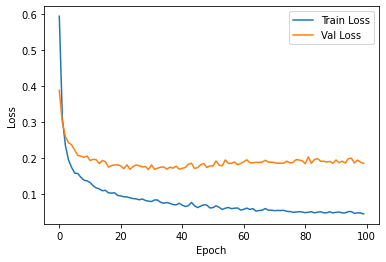

In [45]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

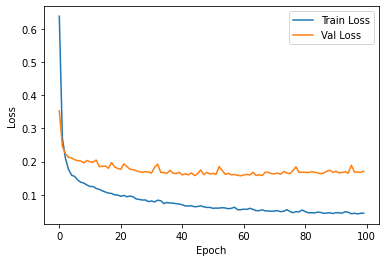

In [50]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Testing the Model

In [51]:
model.evaluate(test_ds)

8/8 [==============================] - 0s 11ms/step - loss: 0.1761 - mean_absolute_error: 0.3038 - root_mean_squared_error: 0.4197


[0.17614656686782837, 0.3037506639957428, 0.41969817876815796]

In [52]:
model.save_weights('my_weights.h5')

In [53]:
y_pred_val = model.predict(test_ds)
scaler_y.inverse_transform(y_pred_val)

array([[11.501047 ],
       [11.715557 ],
       [ 9.547777 ],
       [11.360009 ],
       [11.599024 ],
       [ 9.882989 ],
       [11.495926 ],
       [11.396889 ],
       [10.494368 ],
       [11.974746 ],
       [ 9.880668 ],
       [10.536431 ],
       [10.64443  ],
       [10.978674 ],
       [11.855524 ],
       [10.595988 ],
       [ 9.704764 ],
       [11.142426 ],
       [11.116932 ],
       [11.199216 ],
       [11.94705  ],
       [10.476508 ],
       [10.352137 ],
       [11.158057 ],
       [10.884831 ],
       [11.55923  ],
       [10.760356 ],
       [10.873861 ],
       [10.458692 ],
       [11.687412 ],
       [10.725478 ],
       [10.546942 ],
       [11.739106 ],
       [10.866396 ],
       [10.749381 ],
       [ 9.486362 ],
       [10.595599 ],
       [11.164412 ],
       [10.559087 ],
       [10.931141 ],
       [10.798099 ],
       [10.901221 ],
       [10.954712 ],
       [11.945498 ],
       [10.379394 ],
       [11.634231 ],
       [11.000677 ],
       [10.76

In [51]:
def test_regression_model(test_ds,model,scaler = None):
    y = []
    y_preds = []
    for inputs,labels in test_ds:
        y_pred = model.predict(inputs)
        if scaler:
            labels = scaler_y.inverse_transform(labels)
            y_pred = scaler_y.inverse_transform(y_pred)
        try:
            y.extend(labels.numpy())
        except:
            y.extend(labels)
        y_preds.extend(y_pred)
    return np.squeeze(y),np.squeeze(y_preds)

In [52]:
res = test_regression_model(test_ds,model,scaler = scaler_y)

In [53]:
np.squeeze(res[1])

array([10.041936 ,  9.810069 , 11.858476 , 11.2119875, 10.734035 ,
       11.6458   ,  9.920818 , 10.75022  , 11.372738 , 11.851088 ,
       11.205783 , 11.605615 , 11.1680155, 11.1179085, 10.297432 ,
       11.133019 , 11.258297 , 11.367032 , 10.050701 , 10.605611 ,
       10.260218 , 10.340695 , 10.132229 , 11.269584 , 11.293035 ,
       10.723493 , 11.057717 , 11.65945  , 11.578796 , 10.633372 ,
       11.197065 , 10.702247 , 10.962427 , 10.715699 , 10.793029 ,
       11.053658 , 10.086551 ,  9.855197 , 10.208607 , 10.908213 ,
       10.362743 ,  9.845363 , 10.507664 , 10.2005625, 11.591882 ,
       10.878092 , 10.85452  , 11.113186 ,  9.858717 , 10.771016 ,
       10.63654  , 12.678552 , 11.071238 , 11.149466 , 11.043197 ,
       10.6526375, 11.202668 , 11.382591 ,  9.924012 , 11.370097 ,
       10.931579 , 11.377607 , 11.09911  , 10.455245 , 10.016759 ,
       10.963083 , 11.312687 , 11.65839  , 10.936719 , 11.521207 ,
       11.239635 , 11.461081 ,  9.663891 ,  9.454674 , 11.0871

# Hyperparameter Tuning

Grid search

In [58]:
def model_builder(hp):
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

  inputs = tf.keras.Input(shape=(44,))
  dense1 = Dense(units=hp_units, activation="relu")(inputs)
  dense2 = Dense(units=hp_units,activation=tf.keras.layers.LeakyReLU(alpha=0.2),kernel_initializer=tf.keras.initializers.GlorotUniform())(dense1)
  cat_layer = tf.keras.layers.Concatenate(axis=1)([dense1,dense2])
  out = Dense(1,activation='linear')(cat_layer)

  model = Model(inputs=inputs, outputs=out)

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
              ,loss=tf.keras.losses.MeanSquaredError()
              ,metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])

  return model

In [59]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='exp',
                     project_name='kt')

Reloading Tuner from exp\kt\tuner0.json


In [60]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(x_train,y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [63]:
best_hps.values

{'units': 480,
 'learning_rate': 0.001,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}